### IMPORTS

In [1]:
import openmc
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface
from Aux.CSVObjects import *
from Aux.ReactorPhysicsObjects import *

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle

import pandas as pd

In [2]:
# FLUID
fluid = FluidRelation(cp=1983, mu=0.00744, k=1.44, rho_0 = 2715.13, drho_dT=-0.513)

### BC DATA ###
mdot_csv = load_csv('Data/msre_flow_coastdown.csv')
MDOT_MAX = 158
START_TIME = -100
mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=START_TIME, x_label='time', y_label='mdot')

T_bc = 900
pressure_bc = 0.0




In [3]:
# SET CHANNELS UP FROM FULL CORE SOLUTION (NEED TO RUN COASTDOWN SIMULATION FIRST)
ch1 = Channel.import_from_pkl(filename='Data/model_8_channels/channel_1_setup.pkl')
ch2 = Channel.import_from_pkl(filename='Data/model_8_channels/channel_2_setup.pkl')
ch3 = Channel.import_from_pkl(filename='Data/model_8_channels/channel_3_setup.pkl')
ch4 = Channel.import_from_pkl(filename='Data/model_8_channels/channel_4_setup.pkl')
ch5 = Channel.import_from_pkl(filename='Data/model_8_channels/channel_5_setup.pkl')
ch6 = Channel.import_from_pkl(filename='Data/model_8_channels/channel_6_setup.pkl')
ch7 = Channel.import_from_pkl(filename='Data/model_8_channels/channel_7_setup.pkl')
ch8 = Channel.import_from_pkl(filename='Data/model_8_channels/channel_8_setup.pkl')

upper_plenum_channel = Channel.import_from_pkl(filename='Data/model_8_channels/upper_plenum.pkl')
lower_plenum_channel = Channel.import_from_pkl(filename='Data/model_8_channels/lower_plenum.pkl')
ex_channel = Channel.import_from_pkl(filename='Data/model_8_channels/external_loop.pkl')
downcomer_channel = Channel.import_from_pkl(filename='Data/model_8_channels/downcomer.pkl')


# channel array
ch_arr_list = [ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8]
ratios = [ch1.mdot_bc,ch2.mdot_bc,ch3.mdot_bc,ch4.mdot_bc,ch5.mdot_bc,ch6.mdot_bc,ch7.mdot_bc,ch8.mdot_bc]
ch = ChannelArray(channels=ch_arr_list,
                  coupling_method='ratio_method',
                  flow_ratios=ratios,
                  fluid=fluid,
                  mdot_relaxation=1.0,
                  epsilon=1e-6)
# set bcs for the channel array.
ch.set_bcs(pressure_bc=pressure_bc,
           T_bc=T_bc,
           mdot_bc=mdot_bc,
           tracer_name_value_pairs={}, tracer_bool=False, th_bool=True)




In [4]:
### PRINT CHANNEL RESIDENCE TIMES
print(ch.get_channel_residence_time())
print(upper_plenum_channel.get_channel_residence_time())
print(ex_channel.get_channel_residence_time())
print(downcomer_channel.get_channel_residence_time())
print(lower_plenum_channel.get_channel_residence_time())
print("total residence time =", ch.get_channel_residence_time()
      + upper_plenum_channel.get_channel_residence_time()
      + ex_channel.get_channel_residence_time()
      + downcomer_channel.get_channel_residence_time()
      + lower_plenum_channel.get_channel_residence_time())

8.420001252243992
3.900000005325571
5.457869158342907
1.6763932813804403
3.7999999986064488
total residence time = 23.25426369589936


In [5]:
ch_to_up = ChannelInterface(ch1=ch, ch2=upper_plenum_channel)
up_to_ex = ChannelInterface(ch1=upper_plenum_channel, ch2=ex_channel)
ex_to_downcomer = ChannelInterface(ch1=ex_channel, ch2=downcomer_channel)
downcomer_to_lp = ChannelInterface(ch1=downcomer_channel, ch2=lower_plenum_channel)
lp_to_ch = ChannelInterface(ch1=lower_plenum_channel, ch2=ch)

In [6]:
# st.st. solution for thermal hydraulics
ch.solve_channel_TH(_dt=1e321)
ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

upper_plenum_channel.solve_channel_TH(_dt=1e321)
up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

ex_channel.solve_channel_TH(_dt=1e321)
ex_to_downcomer.update_interface_conditions(tracer_bool=False, th_bool=True)

downcomer_channel.solve_channel_TH(_dt=1e321)
downcomer_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

lower_plenum_channel.solve_channel_TH(_dt=1e321)
lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

# St.St. Solution for tracers
ch_outlet_value = 1.0
iter_num = 0
tracer_to_converge_on = 'c1'
while True:
  iter_num += 1
  ch.solve_all_tracers(_dt=1e321)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum_channel.solve_all_tracers(_dt=1e321)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  ex_channel.solve_all_tracers(_dt=1e321)
  ex_to_downcomer.update_interface_conditions(tracer_bool=True, th_bool=False)

  downcomer_channel.solve_all_tracers(_dt=1e321)
  downcomer_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum_channel.solve_all_tracers(_dt=1e321)
  lp_to_ch.update_interface_conditions(tracer_bool=True, th_bool=False)

  _,_,_,_,tracer_outlet_weighted_value = ch.get_outlet_conditions()
  diff = np.abs(1 - tracer_outlet_weighted_value[tracer_to_converge_on]/ch_outlet_value)

  ch_outlet_value = tracer_outlet_weighted_value[tracer_to_converge_on]
  print("Iteration nuimber", iter_num, " and diff is", diff)
  if diff < 1e-12:
    break

Iteration nuimber 1  and diff is 0.9999999923730752
Iteration nuimber 2  and diff is 6.699030510060044e-05
Iteration nuimber 3  and diff is 4.8885962150690965e-05
Iteration nuimber 4  and diff is 3.5673729553709066e-05
Iteration nuimber 5  and diff is 2.6031975430940157e-05
Iteration nuimber 6  and diff is 1.8995973206314964e-05
Iteration nuimber 7  and diff is 1.3861585727803494e-05
Iteration nuimber 8  and diff is 1.0114910682035294e-05
Iteration nuimber 9  and diff is 7.380904090581453e-06
Iteration nuimber 10  and diff is 5.3858702230291655e-06
Iteration nuimber 11  and diff is 3.930079543357223e-06
Iteration nuimber 12  and diff is 2.8677821960476635e-06
Iteration nuimber 13  and diff is 2.092620745686169e-06
Iteration nuimber 14  and diff is 1.526984233501949e-06
Iteration nuimber 15  and diff is 1.1142389417795329e-06
Iteration nuimber 16  and diff is 8.13058759430163e-07
Iteration nuimber 17  and diff is 5.932877799041947e-07
Iteration nuimber 18  and diff is 4.3292112450465936

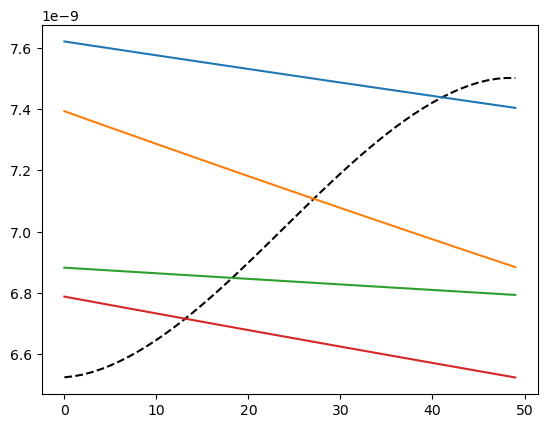

In [7]:
plt.plot(ch.channels[0].tracers['c1'].T, 'k--')
plt.plot(upper_plenum_channel.tracers['c1'].T)
plt.plot(ex_channel.tracers['c1'].T)
plt.plot(downcomer_channel.tracers['c1'].T)
plt.plot(lower_plenum_channel.tracers['c1'].T)

In [12]:
print(ch.integrate_tracer_source(tracer_name='c1'))
print(upper_plenum_channel.integrate_tracer_source(tracer_name='c1'))
print(lower_plenum_channel.integrate_tracer_source(tracer_name='c1'))
print(downcomer_channel.integrate_tracer_source(tracer_name='c1'))


5.936561751705892e-07
5.216420330552755e-08
2.0912990632140712e-08
1.9117083758381587e-08
